<a href="https://colab.research.google.com/github/victorTonny/real-time-sign-language-to-text-conversion/blob/main/MEDICAL_PRESCRIPTION_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
# Install Tesseract OCR
!sudo apt-get install tesseract-ocr
!pip install pytesseract gtts ipywidgets easyocr
!pip install google-cloud-texttospeech


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [29]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import IPython.display as ipd
import os
import sys
import random
import pytesseract
from IPython.display import HTML
from PIL import Image
from io import BytesIO
from gtts import gTTS
import ipywidgets as widgets
import cv2

In [30]:
# Load EasyOCR model for Optical Character Recognition
import easyocr
reader = easyocr.Reader(['en'])

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

In [31]:
csv_file_path = "/content/drive/MyDrive/RADHIA MEDICAL PRESCRIPTION/MEDICINE DATASET/Medicine_Details.csv"
df = pd.read_csv(csv_file_path)

In [32]:
df.shape

(11825, 9)

(11825, 9)

In [33]:
# Define the number of images to display and images per row
num_images_to_display = 12
images_per_row = 4

In [34]:
# Build HTML string to display images
html_content = ""

In [35]:
# Loop through the DataFrame and limit to 10 images
count = 0
for index, row in df.iterrows():
  # Extract image URL and medicine name
  image_url = row["Image URL"]
  medicine_name = row["Medicine Name"]

  # Create a container element for image and name
  container_html = f'<div style="display: inline-block; margin-right: 10px; text-align: center;">'

  # Create image element with styling (replace with desired width/height)
  image_html = f'<img src="{image_url}" width="200px" height="200px" style="border: 1px solid #ddd;">'

  # Create caption element for medicine name
  caption_html = f'<p>{medicine_name}</p>'

  # Combine image and caption within the container
  combined_html = image_html + caption_html

  # Add combined content to the container element
  container_html += combined_html

  # Close the container element
  container_html += '</div>'

  # Add container element to HTML content
  html_content += container_html

  # Add a line break after every `images_per_row` images
  if (count + 1) % images_per_row == 0:
    html_content += "<br>"

  # Stop after displaying the desired number of images
  count += 1
  if count >= num_images_to_display:
    break

# Display the HTML content
display(HTML(html_content))

In [36]:
# Directory containing the images
image_dir = "/content/drive/MyDrive/RADHIA MEDICAL PRESCRIPTION/IMAGES"

In [37]:
# Function to get a sample of images
def get_sample_images(directory, num_samples=5):
    # Get list of all image files in the directory
    image_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    # Randomly select a sample of images
    sample_images = random.sample(image_files, min(num_samples, len(image_files)))
    return sample_images

In [38]:
# Function to display sample images
def display_sample_images(directory, sample_images):
    fig, axes = plt.subplots(1, len(sample_images), figsize=(15, 5))
    fig.suptitle('Sample Images')
    for i, image_file in enumerate(sample_images):
        image_path = os.path.join(directory, image_file)
        image = Image.open(image_path)
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(image_file)
    plt.show()

In [39]:
# Get a sample of images
sample_images = get_sample_images(image_dir, num_samples=5)

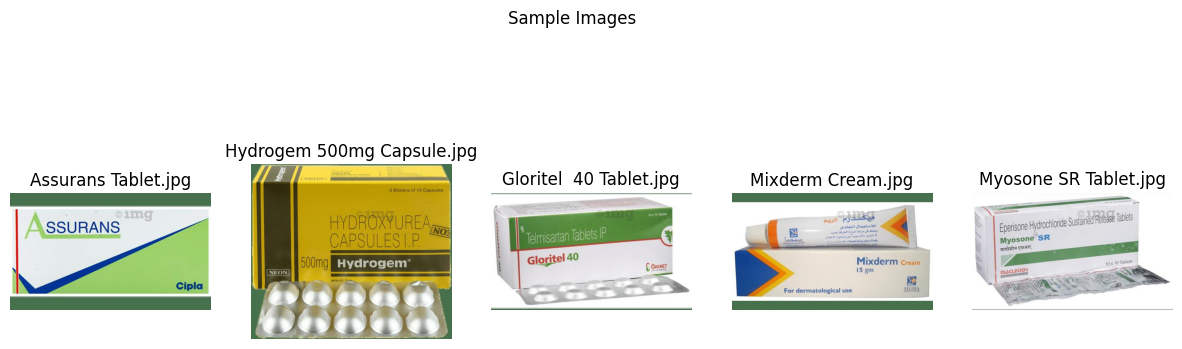

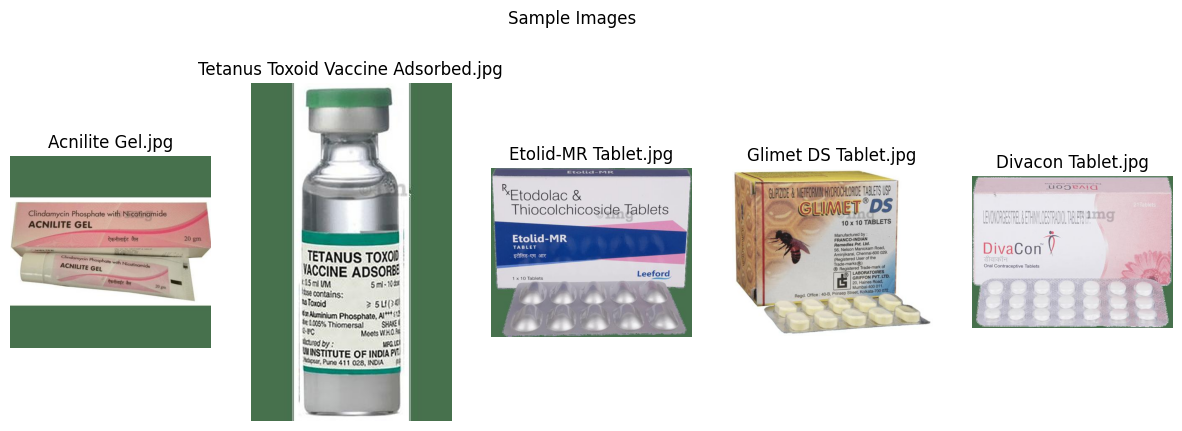

In [40]:
# Display the sample images
display_sample_images(image_dir, sample_images)

In [41]:
# Count the number of image files in the directory
num_images = len([f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))])

print(f"There are {num_images} images in the directory.")

There are 11610 images in the directory.
There are 11610 images in the directory.


In [42]:
image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]

# Randomly select 5 image files
sample_image_files = random.sample(image_files, 5)

In [43]:
# Function to preprocess the image
def preprocess_image(image):
    gray = image.convert('L')
    gray = np.array(gray)
    _, binary = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    denoised = cv2.medianBlur(binary, 3)
    preprocessed_img = Image.fromarray(denoised)
    return preprocessed_img

In [44]:
# Function to extract text from an image using Tesseract OCR
def extract_text_from_image(image):
    preprocessed_img = preprocess_image(image)
    config = '--psm 6 --oem 3'
    text = pytesseract.image_to_string(preprocessed_img, config=config)
    return text.strip()

In [45]:
# Function to convert text to speech
def text_to_speech(text, language='en'):
    tts = gTTS(text=text, lang=language, slow=False)
    return tts

In [46]:
# Function to display image and text
def display_image_and_text(image, text):
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    print("EXTRACTED TEXT IS:")
    print(text)
    print()

In [47]:
import ipywidgets as widgets

In [48]:
# Function to handle file uploads
def handle_upload(change):
    uploaded_files = change['new']

    if uploaded_files:
        uploaded_file = next(iter(uploaded_files.values()))
        image_data = uploaded_file['content']

        try:
            image = Image.open(BytesIO(image_data))
        except Exception as e:
            print(f"Error opening image: {e}")
            return

        text = extract_text_from_image(image)

        if not text:
            text = "There is no medical prescription information extracted from this image."

        display_image_and_text(image, text)

        tts = text_to_speech(text)
        temp_file = "temp.mp3"
        tts.save(temp_file)

        audio = ipd.Audio(temp_file, autoplay=True)
        ipd.display(audio)

# Create the file upload widget
upload_widget = widgets.FileUpload(
    accept='image/*',  # Accept image files only
    multiple=False  # Do not allow multiple file uploads
)

# Attach the handler to the file upload widget
upload_widget.observe(handle_upload, names='value')

# Display the upload widget
display(upload_widget)

FileUpload(value={}, accept='image/*', description='Upload')

FileUpload(value={}, accept='image/*', description='Upload')

Image Preprocessing Enhancements

In [49]:
def preprocess_image(image):
    gray = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2GRAY)
    gray = cv2.bilateralFilter(gray, 11, 17, 17)
    edges = cv2.Canny(gray, 30, 200)
    preprocessed_img = Image.fromarray(edges)
    return preprocessed_img


2. Use Advanced OCR Models

In [50]:
def extract_text_with_easyocr(image):
    reader = easyocr.Reader(['en'])
    results = reader.readtext(np.array(image))
    text = ' '.join([result[1] for result in results])
    return text.strip()


3. Language Model Integration

In [51]:
from textblob import TextBlob

def correct_text(text):
    blob = TextBlob(text)
    corrected_text = blob.correct()
    return str(corrected_text)


4. Enhanced Text-to-Speech

In [52]:
from google.cloud import texttospeech

def text_to_speech_google(text):
    client = texttospeech.TextToSpeechClient()
    synthesis_input = texttospeech.SynthesisInput(text=text)
    voice = texttospeech.VoiceSelectionParams(
        language_code="en-US",
        ssml_gender=texttospeech.SsmlVoiceGender.NEUTRAL
    )
    audio_config = texttospeech.AudioConfig(
        audio_encoding=texttospeech.AudioEncoding.MP3
    )
    response = client.synthesize_speech(
        input=synthesis_input, voice=voice, audio_config=audio_config
    )
    return response.audio_content


5. User Interface Improvements

FileUpload(value={}, accept='image/*', description='Upload')

FloatProgress(value=0.0, description='Processing...', max=1.0)

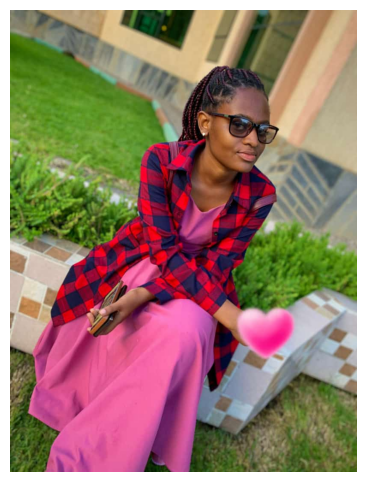

EXTRACTED TEXT IS:
There is no medical prescription information extracted from this image.



In [56]:
# Function to handle file uploads
def handle_upload(change):
    progress = widgets.FloatProgress(min=0, max=1, description='Processing...')
    display(progress)

    uploaded_files = change['new']
    if uploaded_files:
        uploaded_file = next(iter(uploaded_files.values()))
        image_data = uploaded_file['content']

        try:
            image = Image.open(BytesIO(image_data))
        except Exception as e:
            progress.close()
            print(f"Error opening image: {e}")
            return

        progress.value = 0.5  # Update progress

        text = extract_text_with_easyocr(image)
        if not text:
            text = "There is no medical prescription information extracted from this image."

        corrected_text = correct_text(text)

        display_image_and_text(image, corrected_text)

        tts = text_to_speech(corrected_text)
        temp_file = "temp.mp3"
        tts.save(temp_file)

        audio = ipd.Audio(temp_file, autoplay=True)
        ipd.display(audio)

        progress.value = 1  # Update progress
        progress.close()

# Create the file upload widget
upload_widget = widgets.FileUpload(
    accept='image/*',  # Accept image files only
    multiple=False  # Do not allow multiple file uploads
)

# Attach the handler to the file upload widget
upload_widget.observe(handle_upload, names='value')

# Display the upload widget
display(upload_widget)

# **Step 3: Create the Webcam Capture Form**

In [59]:
import base64
import easyocr
import ipywidgets as widgets
from IPython.display import Javascript, display, HTML
from gtts import gTTS
import IPython.display as ipd
from PIL import Image
import io
import numpy as np

# Initialize the EasyOCR reader
reader = easyocr.Reader(['en'])

# Apply preprocessing techniques to enhance image quality
def preprocess_image(image):
    # Resize image to a fixed size
    resized_image = image.resize((800, 600))
    return resized_image

# Function to perform OCR on the frame with preprocessing
def performOCR(frame_data):
    # Decode the frame data from base64
    frame_bytes = base64.b64decode(frame_data.split(',')[1])
    frame_image = Image.open(io.BytesIO(frame_bytes))

    # Preprocess the image
    preprocessed_image = preprocess_image(frame_image)

    # Convert the preprocessed image to a numpy array
    preprocessed_array = np.array(preprocessed_image)

    # Perform OCR using EasyOCR on the preprocessed image
    results = reader.readtext(preprocessed_array)
    text = ' '.join([result[1] for result in results])

    return text

# Function to convert text to speech using gTTS
def speak_text(text):
    tts = gTTS(text=text, lang='en', slow=False)
    temp_file = "temp.mp3"
    tts.save(temp_file)

    with open(temp_file, "rb") as f:
        audio_data = f.read()

    audio_base64 = base64.b64encode(audio_data).decode('utf-8')
    return audio_base64

# Function to process video frames
def process_video_frame(frame):
    # Perform OCR on the frame
    text = performOCR(frame)

    if text:
        print('Extracted text:', text)

        # Convert text to speech and play
        audio_base64 = speak_text(text)
        audio_tag = f'<audio controls autoplay src="data:audio/mp3;base64,{audio_base64}"></audio>'
        display(HTML(audio_tag))

# Function to start the video stream in the browser
def start_video_stream(_):
    # JavaScript code to access the webcam stream
    js_code = """
    (async () => {
        const video = document.createElement('video');
        const stream = await navigator.mediaDevices.getUserMedia({ video: true });
        video.srcObject = stream;
        document.body.appendChild(video);
        await video.play();

        // Add heading for the camera feed
        const heading = document.createElement('h2');
        heading.textContent = 'Real Time Video Capture';
        document.body.insertBefore(heading, video);

        // Canvas to draw video frames
        const canvas = document.createElement('canvas');
        const context = canvas.getContext('2d');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        document.body.appendChild(canvas);

        // Add heading for the output captured
        const outputHeading = document.createElement('h2');
        outputHeading.textContent = 'Output that is Captured';
        document.body.appendChild(outputHeading);

        // Continuous processing of video frames
        setInterval(async () => {
            context.drawImage(video, 0, 0, canvas.width, canvas.height);
            const frame = canvas.toDataURL('image/jpeg');

            // Perform OCR on the frame
            const response = await google.colab.kernel.invokeFunction('process_video_frame', [frame], {});
            const text = response.data['application/json'];

            // Display or read the extracted text
            if (text) {
                // Display the text
                console.log('Extracted text:', text);

                // Convert text to speech and play
                const audio_response = await google.colab.kernel.invokeFunction('speak_text', [text], {});
                const audio_base64 = audio_response.data['text/plain'];
                const audio_tag = `<audio controls autoplay src="data:audio/mp3;base64,${audio_base64}"></audio>`;
                document.body.innerHTML += audio_tag;
            }
        }, 5000); // Process every 5 seconds
    })();
    """

    # Execute the JavaScript code
    display(Javascript(js_code))

# Create button to start video stream
start_stream_button = widgets.Button(description="Start Video Stream")

# Attach the event handler to the button
start_stream_button.on_click(start_video_stream)

# Display the button
display(start_stream_button)

# Register the functions with Google Colab
from google.colab import output
output.register_callback('process_video_frame', process_video_frame)
output.register_callback('speak_text', speak_text)


Button(description='Start Video Stream', style=ButtonStyle())